# Entender Problema

-- Objetivo do Problema:
    -- 1.0. Previsao do primeiro destino que um novo usuário irá escolher.
    
    -- Porque?
        -- Qual tipo de modelo de negócio do Airbnb?
            -- Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
            -- Oferta ( pessoas oferecendo acomodacao )
                -- Tamanho do portfólio.
                -- Diversidade/Densidade de Portfólio.
                -- Preco Medio
                
            -- Demanda ( pessoas procurando acomodacao )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client Acquisition Cost )
                
                
               Gross Revenue = ( Fee*Numero cliente ) - CAC 
    
-- Proposta da Solucao

    --- Modelo de Predivao do primeiro destino de um novo usario.
    --- 1.0. Predicoes e salva em tabela do banco de dados. 
    --- 2.0. API 
            --- Input: usuario e suas caracteristicas
            --- Output: usuario e suas caracteristicas com a **predicao do destino**
            
    --- 16 ciclos

# 0.0. Imports

In [39]:
import random
import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt
from scipy      import stats           as ss

from imblearn   import under_sampling  as us
from imblearn   import over_sampling   as oversamp
from imblearn   import combine         as c

from category_encoders import TargetEncoder

from pandas_profiling import ProfileReport

from keras import models as ml
from keras import layers as l

## 0.1. Helper Functions

In [40]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading Data

In [41]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )
df_raw.shape

(213451, 16)

In [42]:
df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [43]:
df1 = df_raw.copy()

## 1.1. Data Dimension

In [44]:
print( 'Number of rows: {}'.format( df1.shape[0] ) )
print( 'Number of columns: {}'.format( df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


In [45]:
print( 'Number of rows: {}'.format( df_sessions.shape[0] ) )
print( 'Number of columns: {}'.format( df_sessions.shape[1] ) )

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type

In [46]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [47]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [48]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [49]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [54]:
# remove missing value completly
#df1 = df1.dropna()

# ========== User =================
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = np.int64(df1['age'].mean())
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# ========== Sessions =================
# user_id - 0.3%
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

# action - 0.7%
df_sessions = df_sessions[~df_sessions['action'].isna()]

# action_type - 11%
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

# action_detail - 11%
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

# secs_elapsed - 1.2%
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

In [55]:
df1.isna().sum() / len( df1 )

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

In [56]:
df_sessions.isna().sum() / len( df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

## 1.4. Change Data Type

In [57]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [58]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

## 1.5. Check Balanced Data

In [59]:
#df1['country_destination'].value_counts( normalize=True )
df1['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 1.6. Descriptive Analysis

In [60]:
# Users
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

# Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int64', 'float64'] )
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'] )

### 1.6.1. Numerical - Users

In [61]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2. Numerical - Sessions

In [62]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame( num_attributes_sessions.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes_sessions.apply( np.median ) ).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes_sessions.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes_sessions.apply( min ) ).T
d3 = pd.DataFrame( num_attributes_sessions.apply( max ) ).T
d4 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes_sessions.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
ct = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3. Categorial - Users

In [63]:
cat_attributes.drop( 'id', axis=1 ).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4. Categorial - Sesssions

In [64]:
cat_attributes_sessions.drop( 'user_id', axis=1 ).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


### 1.6.5. Correlation Matrix - Sessions

In [65]:
cat_attributes_list = cat_attributes_sessions.drop( 'user_id', axis=1 ).columns.tolist()

corr_dict = {}
for i in range( len ( cat_attributes_list ) ):
    corr_list = []
    for j in range( len( cat_attributes_list ) ):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v( cat_attributes_sessions[ ref ], cat_attributes_sessions[ feat ] )
        
        # append a list
        corr_list.append( corr )
    
    # appende a correlation list for each ref attributs
    corr_dict[ ref ] = corr_list

<AxesSubplot:>

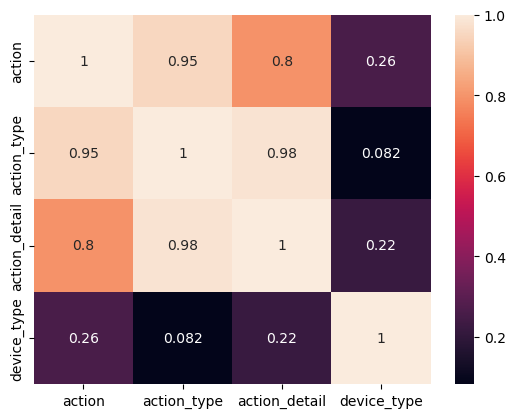

In [66]:
d = pd.DataFrame( corr_dict )
d = d.set_index( d.columns)
sns.heatmap( d, annot=True )

# 2.0. Feature Engineering

In [67]:
df2 = df1.copy()
df2.shape

(122636, 16)

In [68]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1. Create New Features

In [69]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_first_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_first_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

C:\Users\Cliente\AppData\Local\Temp\ipykernel_5968\1420231156.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
C:\Users\Cliente\AppData\Local\Temp\ipykernel_5968\1420231156.py:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
C:\Users\Cliente\AppData\Local\Temp\ipykernel_5968\1420231156.py:57: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [70]:
df2.shape

(122636, 35)

In [71]:
df2[['id', 'date_account_created', 'day_account_created', 'day_first_booking']].sample(10)

,id,date_account_created,day_account_created,day_first_booking
103980,o7e9rxbsei,2013-09-01,1,3
198304,jeqgsyfhsb,2014-06-02,2,26
96792,p0124bui7d,2013-08-05,5,29
121385,qa9r0e9nmu,2013-11-03,3,3
25261,g6nfw8tec2,2012-05-24,24,29
90040,4hcj3y11p1,2013-07-10,10,29
108109,1oxdtb9cl5,2013-09-16,16,16
45688,6xsxt72vv6,2012-10-21,21,24
124999,ycc42jgcmt,2013-11-16,16,29
192798,0ga6e0f8o2,2014-05-21,21,21


# 3.0. Data Filtering

In [72]:
a = [2100, 3500, 4000, 8000, 10000, 16000]
b = [19, 28, 29, 30, 31, 32]

( 19 - np.mean( b ) ) / np.std( b )

-2.132808519406074

In [73]:
np.mean( b )

28.166666666666668

In [74]:
np.std( b )

4.297932319409209

In [75]:
df3 = df2.copy()
df3.shape

(122636, 35)

## 3.1. Filtering Rows

In [76]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]

## 3.2. Columns Selection

In [77]:
cols = ['date_account_created', 'date_account_created', 'date_first_booking', 'timestamp_first_active', 
        'first_active'] # original datetime

# 4.0. Balanced Dataset

In [78]:
df4 = df3.drop( cols, axis=1 )
df4.shape

(122636, 31)

In [79]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes( include=['int64', 'float64'] ).columns.tolist()

# Categorical
col_cat = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ).drop( ['id', 'country_destination'], axis=1 ).columns.tolist()

# encoding
df4_dummy = pd.DataFrame( ohe.fit_transform( df4[ col_cat] ).toarray(), index=df4.index )

# join numerical and categorical
df42 = pd.concat( [df4[col_num], df4_dummy], axis=1 )
df42.shape

(122636, 138)

## 4.1. Random Undersampling

In [80]:
# ratio_balanced
ratio_balanced = {'NDF': 10000 }
# define sampler
undersampling = us.RandomUnderSampler( sampling_strategy=ratio_balanced, random_state=32 )

# apply sampler
X_under, y_under = undersampling.fit_resample( df42, df4['country_destination'] )

C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [81]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [82]:
y_under.value_counts()

US       48057
NDF      10000
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

## 4.2. Random Oversampling

In [83]:
# ratio_balanced
#ratio_balanced = {'NDF': 10000 }

# define sampler
oversampling = oversamp.RandomOverSampler( sampling_strategy='all', random_state=32 )

# apply sampler
X_over, y_over = oversampling.fit_resample( df42, df4['country_destination'] )

C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [84]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [85]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

In [86]:
ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}

In [87]:
# define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( df42, df4['country_destination'] )

C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [88]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [89]:
y_smt.value_counts()

NDF      54850
GB       52689
ES       50507
NL       47598
US       47545
PT       47100
other    44758
FR       43871
CA       42542
IT       40202
DE       37830
AU       36803
Name: country_destination, dtype: int64

In [90]:
# numerical data
df43 = X_smt[ col_num ]

# categorical data
df44 = X_smt.drop( col_num, axis=1 )
df45 = pd.DataFrame( ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index )

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

# 5.0. Exploratory Data Analysis ( EDA )

## 5.1. Hypothesys Validation ( Unbalanced Dataset )

In [91]:
df51 = df4.copy()

### **H01.** Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativacao.

**Verdadeiro.** Em todos os destinos, os usuários até 6 dias para reservar o primeiro Airbnb

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

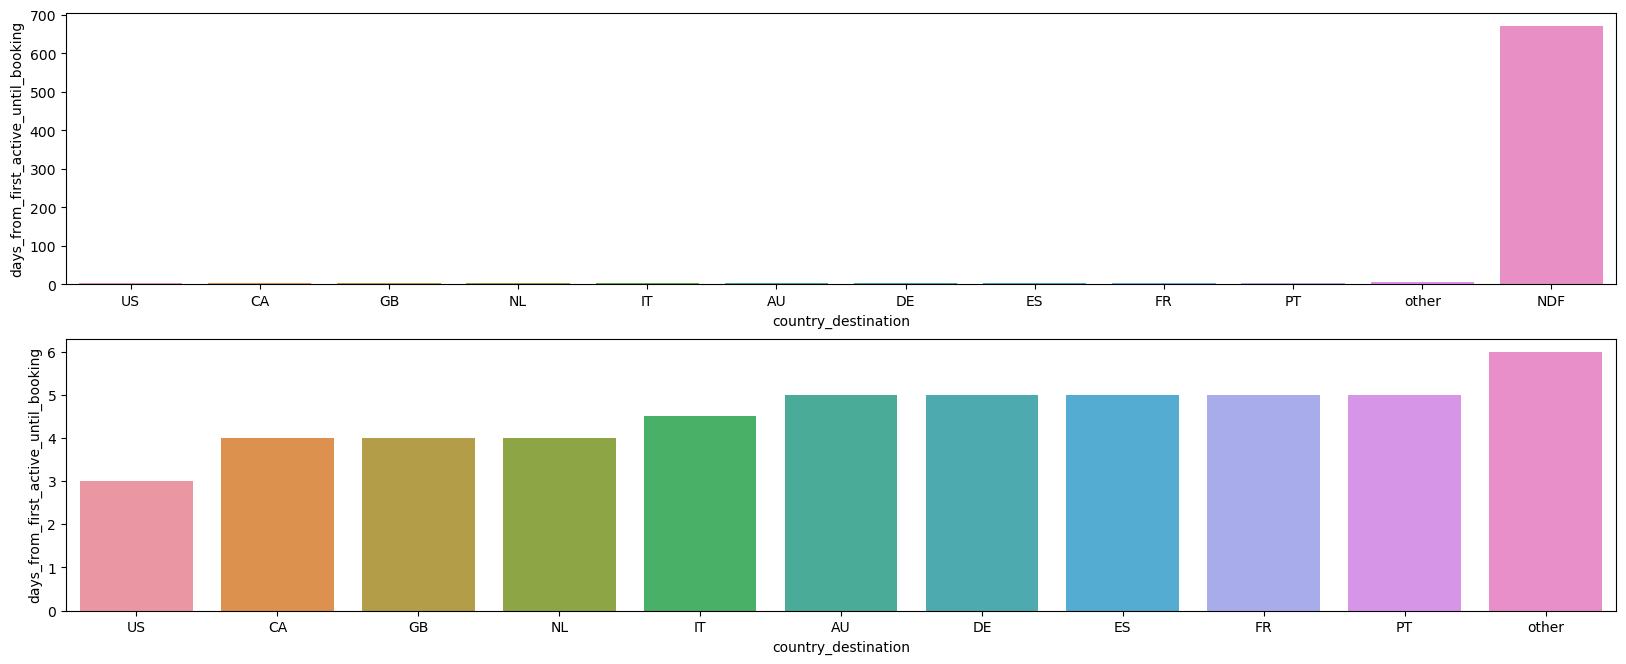

In [92]:
plt.figure( figsize=(20, 12))
plt.subplot( 3, 1, 1 )
aux01 = df51[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux01.sort_values( 'days_from_first_active_until_booking' ) )

# remove outlier
plt.subplot( 3, 1, 2 )
aux02 = df51[df51['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby( 'country_destination' ).median().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_booking', 
             data=aux02.sort_values( 'days_from_first_active_until_booking' ) )

### **H02.** Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.
**Verdadeira**. Em todos os destinos, os usuários levam até 2 dias para finalizar o cadastro

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

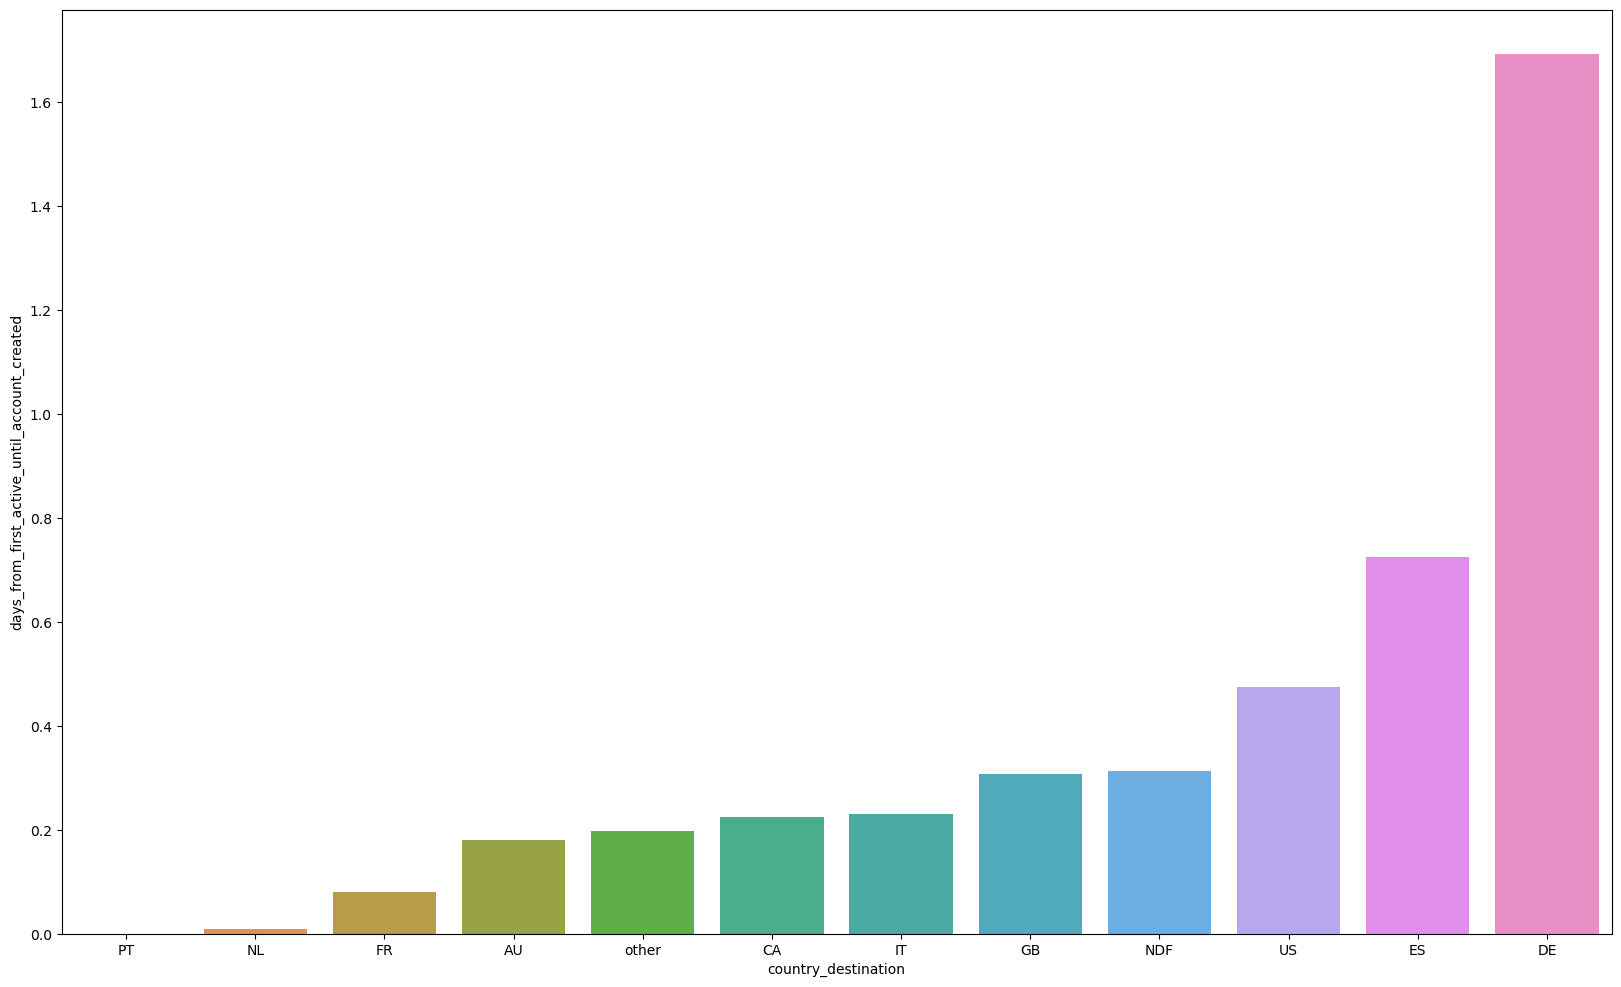

In [93]:
plt.figure( figsize=(20, 12))
aux01 = df51[['days_from_first_active_until_account_created', 'country_destination']].groupby( 'country_destination' ).mean().reset_index()
sns.barplot( x='country_destination', y='days_from_first_active_until_account_created', 
             data=aux01.sort_values( 'days_from_first_active_until_account_created' ) )

### **H03.** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA. 

**False**. O Volume de reservas aumenta durante o verão entre os anos de 2010 até 2013.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

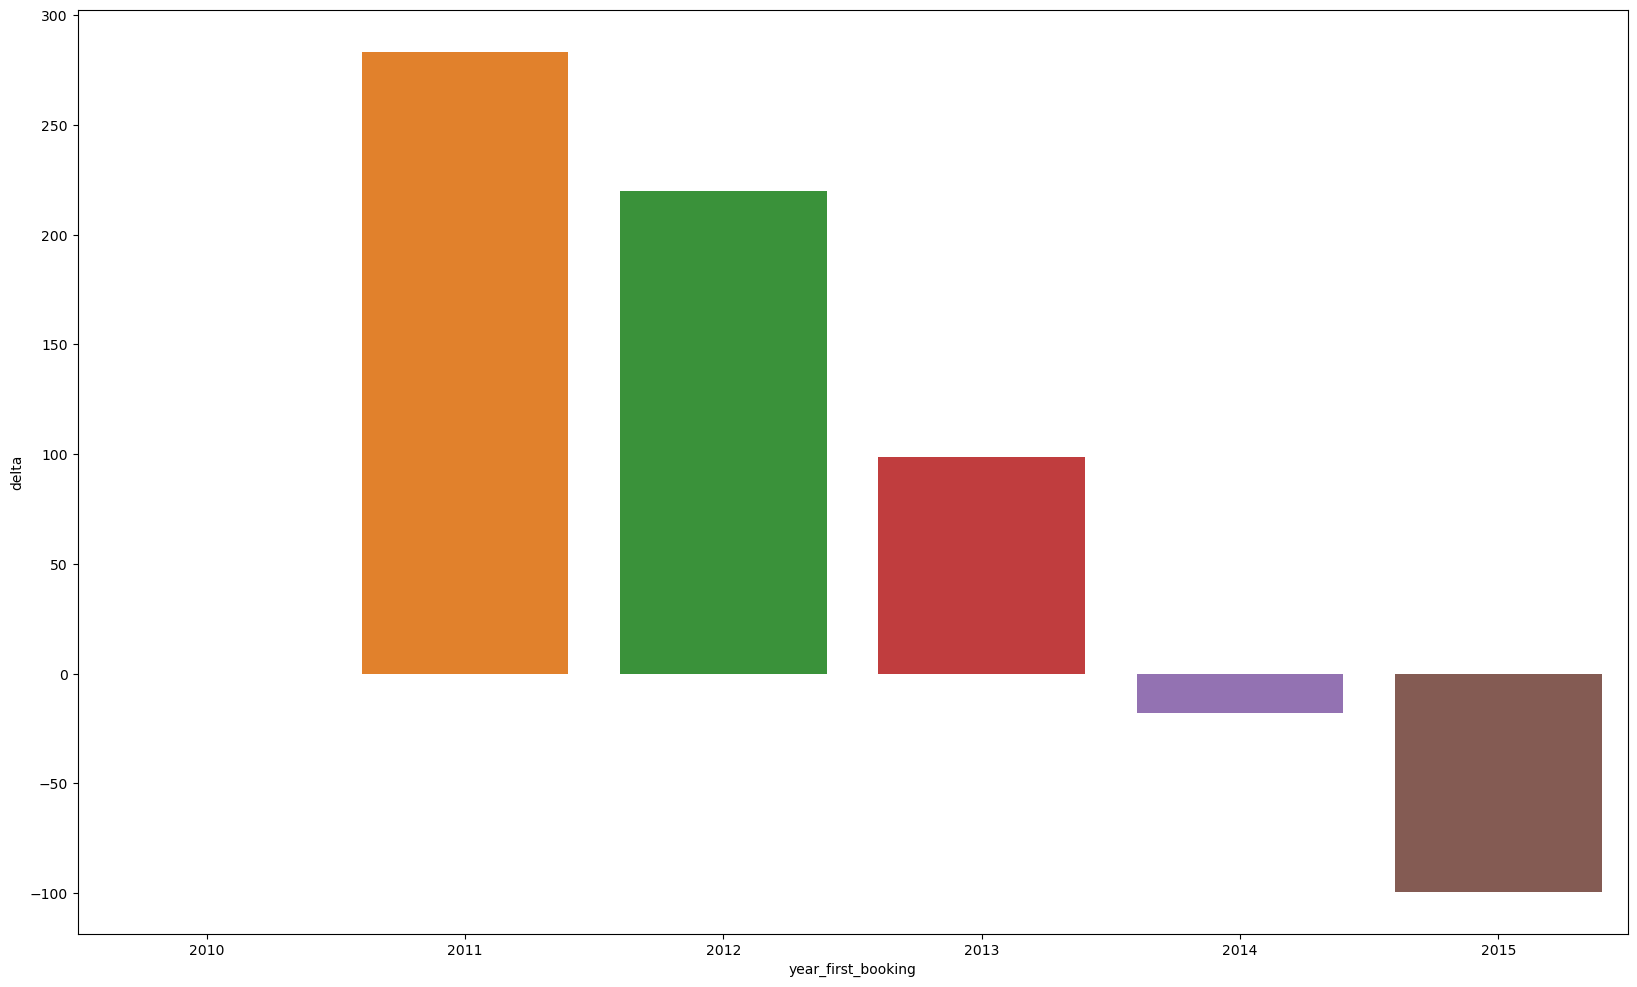

In [94]:
aux01 = df51[['year_first_booking', 'month_first_booking', 'country_destination']].\
                groupby( ['year_first_booking', 'month_first_booking', 'country_destination'] ). \
                size().reset_index().rename( columns={0:'count'})

# select only summer
aux01 = aux01[( aux01['month_first_booking'].isin( [6, 7, 8, 9] ) ) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby( 'year_first_booking' ).sum().reset_index()

aux02['delta'] = 100*aux02['count'].pct_change().fillna( 0 )

plt.figure( figsize=(20,12))
sns.barplot( x='year_first_booking', y='delta', data=aux02)

**H04.** Usuários do sexo feminino fazem 10% mais reservas para países fora dos USA.

**H05.** O canal de Marketing Google representa 40% das reservas para países fora dos USA.

**H06.** O destino dos USA representam mais de 20% em todos os canais.

**H07.** A idade média das pessoas é de 35 anos em todos os destinos.

**H08.** A porcentagem de usuários que usam o site na lingua inglês-americano para reservar acomodações em qualquer destino é maior que 90%

**H09.** O número de reservas do Airbnb é crescente ou decrescente ao longo dos anos?

**H10.** O número de reservas do Airbnb é crescente ao longo dos anos.

## 5.2. Variables Impact ( Balanced Dataset )

In [95]:
df52 = df4.copy()

### 5.2.1. Univariate Analysis

In [96]:
profile = ProfileReport( df52, title='Airbnb Booking' )
#profile.to_notebook_iframe()
profile.to_file( output_file='airbnb_booking_statistics_after_cleaning.html' )

Summarize dataset:   0%|          | 0/46 [00:00<?, ?it/s]

C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\scipy\stats\_stats_py.py:5215: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Cliente\AppData\Local\Temp\ipykernel_5968\3791376659.py", line 3, in <cell line: 3>
    profile.to_file( output_file='airbnb_booking_statistics_after_cleaning.html' )
  File "C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\pandas_profiling\profile_report.py", line 256, in to_file
    data = self.to_html()
  File "C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\pandas_profiling\profile_report.py", line 359, in to_html
    return self.html
  File "C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\pandas_profiling\profile_report.py", line 179, in html
    self._html = self._render_html()
  File "C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\pandas_profiling\profile_report.py", line 286, in _ren

In [ ]:
# ===================== High Correlation  ===================== 
# days_from_first_active_until_booking x days_from_account_created_until_first_booking
# Remove: days_from_first_active_until_booking

# year_first_active x year_account_created
# Remove: year_first_active

# month_first_active x month_account_created
# Remove: month_first_active

# day_first_active x day_account_created
# Remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# Remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# Remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# Remove: month_first_booking

# month_account_created x week_of_year_account_created
# Remove: month_account_created

# year_first_booking x year_account_created
# Remove: year_first_booking

# week_of_year_first_booking x week_of_year_account_created
# Remove: week_of_year_first_booking

# affiliate_channel x affiliate_provider
# Remove: affiliate_provider

# first_device_type x first_browser
# Remove: first_browser

#first_device_type x sigup_app
#Remove: first_device_type

### 5.2.2. Bivariate Analysis

### 5.2.3. Multivariate Analysis

In [97]:
cols = ['days_from_first_active_until_booking',  'year_first_active',  'month_first_active', 'day_first_active',
        'day_of_week_first_active', 'week_of_year_first_active', 'month_first_booking', 'month_account_created',
        'year_first_booking', 'week_of_year_first_booking', 'affiliate_provider',
        'first_browser', 'first_device_type', 'language'] # high correlation

# 6.0. Data Preparation

In [98]:
df6 = df46.drop( cols, axis=1 )
df6.shape

(546295, 16)

In [99]:
df6.dtypes

age                                               int64
signup_flow                                       int64
days_from_first_active_until_account_created      int64
days_from_account_created_until_first_booking     int64
day_first_booking                                 int64
day_of_week_first_booking                         int64
year_account_created                              int64
day_account_created                               int64
day_of_week_account_created                       int64
week_of_year_account_created                      int64
gender                                           object
signup_method                                    object
affiliate_channel                                object
first_affiliate_tracked                          object
signup_app                                       object
country_destination                              object
dtype: object

## 6.1. Rescaling

In [100]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [101]:
# age - Standardization
df6['age'] = ss.fit_transform( df6[['age']].values )

# signup_flow - Robust Scaler
df6['signup_flow'] = rs.fit_transform( df6[['signup_flow']].values )

# days_from_first_active_until_account_created - Robust Scaler
df6['days_from_first_active_until_account_created'] = rs.fit_transform( df6[['days_from_first_active_until_account_created']].values )

# days_from_account_created_until_first_booking - Robust Scaler
df6['days_from_account_created_until_first_booking'] = rs.fit_transform( df6[['days_from_account_created_until_first_booking']].values )

# year_account_created - MinMax Scaler
df6['year_account_created'] = mms.fit_transform( df6[['year_account_created']].values )

## 6.2. Encoding

In [102]:
te = TargetEncoder()

C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\Cliente\.conda\envs\Airbnb_new_users\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [103]:
# gender - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['gender'], columns=['gender'] )

# signup_method - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_method'], columns=['signup_method'] )

# signup_app - One Hot Encoder
df6 = pd.get_dummies( df6, prefix=['signup_app'], columns=['signup_app'] )

# affiliate_channel - Target Encoder
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform( df6[['affiliate_channel']].values, df6['country_destination'].map( c ) )

# first_affiliate_tracked - Target Encoder
df6['first_affiliate_tracked'] = te.fit_transform( df6[['first_affiliate_tracked']].values, df6['country_destination'].map( c ) )

## 6.3. Transformation

In [104]:
# week_of_year_account_created
df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply( lambda x: np.sin( x * (2*np.pi/52 ) ) )
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply( lambda x: np.cos( x * (2*np.pi/52 ) ) )

# day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# day_account_created
df6['day_account_created_sin'] = df6['day_account_created'].apply( lambda x: np.sin( x * (2*np.pi/31 ) ) )
df6['day_account_created_cos'] = df6['day_account_created'].apply( lambda x: np.cos( x * (2*np.pi/31 ) ) )

# day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply( lambda x: np.sin( x * (2*np.pi/7 ) ) )
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply( lambda x: np.cos( x * (2*np.pi/7 ) ) )

# 7.0. Feature Selection

In [105]:
df7 = df6.copy()

In [106]:
X = df6.drop( 'country_destination', axis=1 )
y = df6['country_destination'].copy()

In [107]:
# Split dataset into training and test
x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 8.0. Machine Learning Model

## 8.1. Baseline Model

In [108]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )

### 8.1.1. Baseline Model Performance

Accuracy: 0.09273377936829003
Balanced Accuracy:0.08394439191917935
Kappa Score: 0.0008486738734591048
              precision    recall  f1-score   support

          AU       0.07      0.00      0.01      7408
          CA       0.07      0.01      0.01      8460
          DE       0.06      0.01      0.01      7394
          ES       0.11      0.02      0.03     10143
          FR       0.08      0.03      0.04      8909
          GB       0.09      0.01      0.02     10456
          IT       0.07      0.02      0.03      8005
         NDF       0.10      0.46      0.17     10844
          NL       0.09      0.01      0.01      9608
          PT       0.06      0.00      0.00      9515
          US       0.09      0.39      0.14      9573
       other       0.08      0.06      0.07      8944

    accuracy                           0.09    109259
   macro avg       0.08      0.08      0.05    109259
weighted avg       0.08      0.09      0.05    109259



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

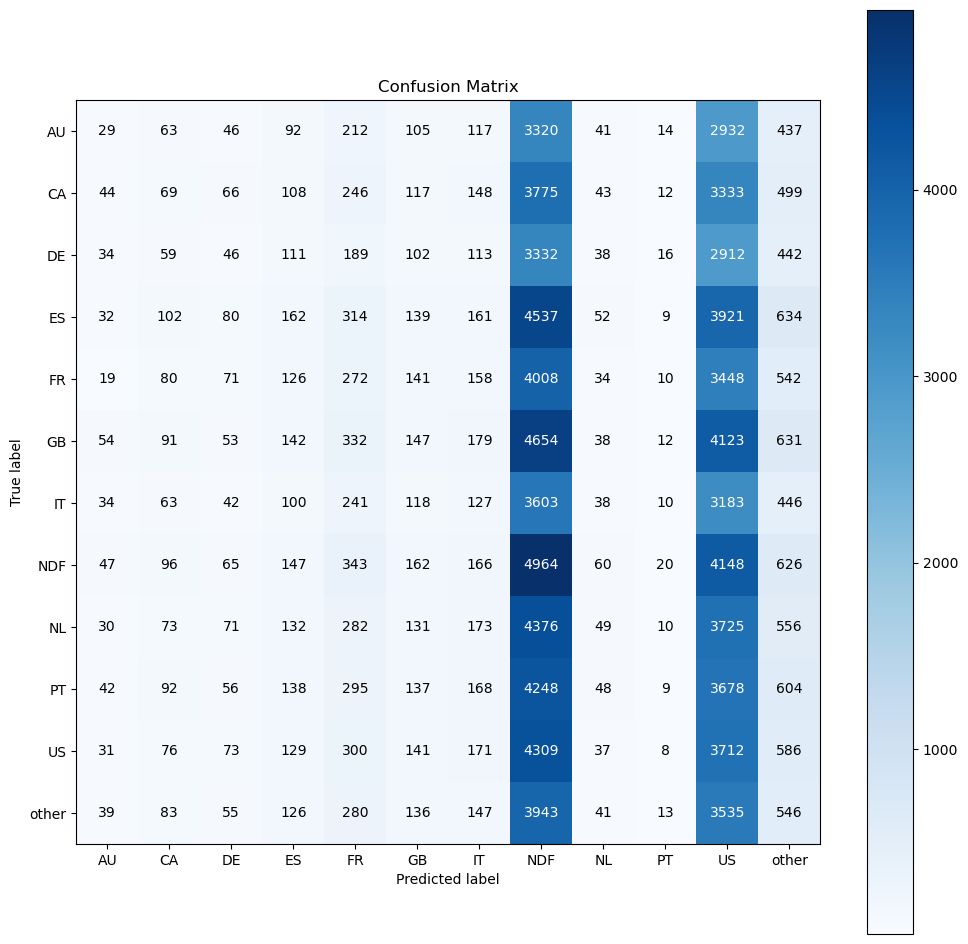

In [109]:
# Accuracy
acc_random = m.accuracy_score( y_test, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_test, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_test, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_test, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 8.2. Neural Network - MLP

In [110]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [111]:
print( 'Number of Rows: {}'.format( x_train.shape[0] ) )
print( 'Number of Features: {}'.format( x_train.shape[1] ) )
print( 'Number of Classes: {}'.format( y_train.nunique() ) )

Number of Rows: 437036
Number of Features: 31
Number of Classes: 12


In [112]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 64, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 12, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
13658/13658 [==============================] - 24s 2ms/step - loss: 2.1232 - accuracy: 0.2466
Epoch 2/100
 1581/13658 [==>...........................] - ETA: 21s - loss: 2.0431 - accuracy: 0.2711

KeyboardInterrupt: 

### 7.2.1. NN Performance

In [98]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

Accuracy: 0.35109284615947867
Balanced Accuracy:0.33314777646607335
Kappa Score: 0.29028000162482237
              precision    recall  f1-score   support

          AU       0.32      0.37      0.34      7470
          CA       0.20      0.21      0.20      8517
          DE       0.21      0.14      0.17      7462
          ES       0.20      0.19      0.19     10003
          FR       0.15      0.07      0.10      8741
          GB       0.19      0.15      0.17     10489
          IT       0.16      0.08      0.10      7962
         NDF       1.00      1.00      1.00     11058
          NL       0.24      0.50      0.32      9675
          PT       0.60      0.92      0.73      9465
          US       0.26      0.30      0.28      9435
       other       0.17      0.07      0.10      8979

    accuracy                           0.35    109256
   macro avg       0.31      0.33      0.31    109256
weighted avg       0.32      0.35      0.32    109256



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

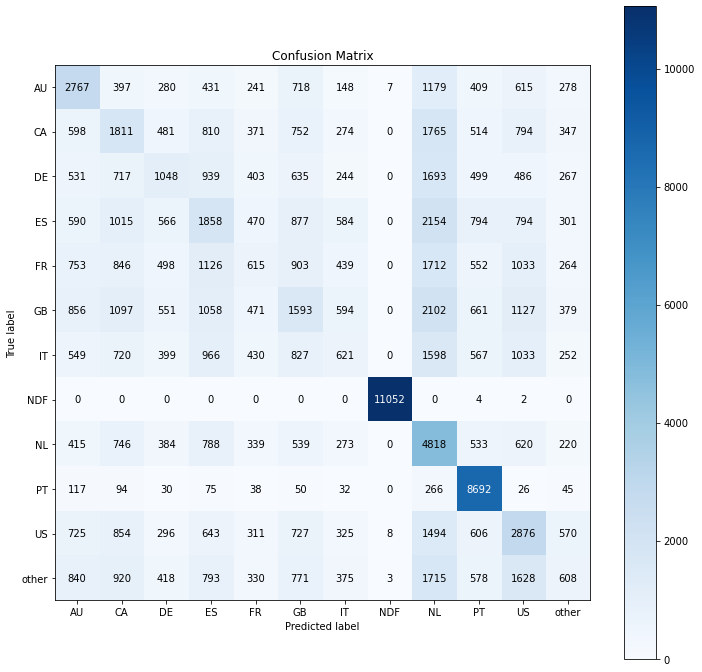

In [99]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Balanced Accuray
balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
print( 'Balanced Accuracy:{}'.format( balanced_acc_nn ) )

# Kappa Metrics
kappa_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
print( 'Kappa Score: {}'.format( kappa_nn ) )

# Classification report
print( m.classification_report( y_test_nn, yhat_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 7.2.2. NN Performance - Cross-Validation

In [53]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 12, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [61]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.round( np.mean( balanced_acc_list ), 4 ), np.round( np.std( balanced_acc_list ), 4 ) ) )
print( 'Avg Kappa: {} +/- {}'.format( np.round( np.mean( kappa_acc_list ), 4 ), np.round( np.std( kappa_acc_list ), 4 ) ) )

Avg Balanced Accuracy: 0.1666 +/- 0.0001
Avg Kappa: 0.724 +/- 0.0006
